# Medición de tiempos de ejecución


## Explorando los datos

In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd

df_train = pd.read_csv("../data/train.csv")
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB


In [2]:
X = df_train[df_train.columns[1:]].values
y = df_train["label"].values.reshape(-1, 1)

X.shape, y.shape

((42000, 784), (42000, 1))

In [3]:
class KNNnPCAClassifier:
    def __init__(self, k, alpha):
        self.knn_classifier = metnum.KNNClassifier(k, "uniform")
        self.pca = metnum.PCA(alpha)

    def fit(self, X_train, y_train):
        self.pca.fit(X_train)
        self.knn_classifier.fit(self.pca.transform(X_train), y_train)
    
    def predict(self, X):
        return self.knn_classifier.predict(self.pca.transform(X))

### Comparativa de tiempo de ejecucion de nuestros mejores classifiers para diferentes particiones

In [4]:
%%time
import time
import metnum
import pandas as pd

from scoring import metrics
from scoring import cross_validation as cv
from tqdm import tqdm

scoring_fn = metrics.accuracy_score
classifiers = {
    "knn":     metnum.KNNClassifier(4, "distance_pow"),
    "knn+pca": KNNnPCAClassifier(6, 34),
}

size =  X.shape[0]
splits = {
    "20-80": int(0.2 * size),
    "50-50": int(0.5 * size),
    "80-20": int(0.8 * size),
}

rows = []

ITER = range(1, 10)

for _ in tqdm(ITER, "iter"):
    for clf_id, clf in tqdm(classifiers.items(), "clf"):
        for split_id, split in tqdm(splits.items(), "split"):
            X_train, y_train = X[:split], y[:split]
            X_val, y_val = X[split:], y[split:]

            # fit
            start = time.time()
            clf.fit(X_train, y_train.ravel())
            fit_elapsed = time.time() - start

            # predict
            start = time.time()
            clf.predict(X_val)
            predict_elapsed = time.time() - start

            # all
            total_elapsed = fit_elapsed + predict_elapsed
            rows.append({
                "split": split_id,
                "sample_size": size,
                "fit_elapsed": fit_elapsed,
                "predict_elapsed": predict_elapsed,
                "total_elapsed": total_elapsed,
                "clf": clf_id,
            })

print("Creating DataFrame...")
df = pd.DataFrame(rows)
df.to_csv("data/time/exec_time.csv", index=False)
print("Finished!")

clf:   0%|          | 0/2 [00:00<?, ?it/s]

split:   0%|          | 0/3 [00:00<?, ?it/s]

split:  33%|███▎      | 1/3 [03:21<06:42, 201.28s/it]

split:  67%|██████▋   | 2/3 [08:34<03:54, 234.81s/it]

split: 100%|██████████| 3/3 [11:54<00:00, 238.18s/it]

clf:  50%|█████     | 1/2 [11:54<11:54, 714.54s/it]

split:   0%|          | 0/3 [00:00<?, ?it/s]

split:  33%|███▎      | 1/3 [00:11<00:23, 11.79s/it]

split:  67%|██████▋   | 2/3 [00:32<00:14, 14.42s/it]

split: 100%|██████████| 3/3 [00:47<00:00, 15.85s/it]

clf:   0%|          | 0/2 [00:00<?, ?it/s]

split:   0%|          | 0/3 [00:00<?, ?it/s]

split:  33%|███▎      | 1/3 [03:20<06:41, 200.74s/it]

split:  67%|██████▋   | 2/3 [08:35<03:54, 234.94s/it]

split: 100%|██████████| 3/3 [11:56<00:00, 238.94s/it]

clf:  50%|█████     | 1/2 [11:56<11:56, 716.83s/it]

split:   0%|          | 0/3 [00:00<?, ?it/s]

split:  33%|███▎      | 1/3 [00:12<00:24, 12.44s/it]

split:  67%|██████▋   | 2/3 [00:31<00:14, 14.52s/it]

split: 100%|██████████

Creating DataFrame...
Finished!
CPU times: user 1h 54min 34s, sys: 37.1 s, total: 1h 55min 11s
Wall time: 1h 54min 15s


## Analisis de resultados

In [24]:
import pandas as pd

df = pd.read_csv("data/time/exec_time.csv")

Text(0.5, 1.0, 'Tiempos de predict por classifier')

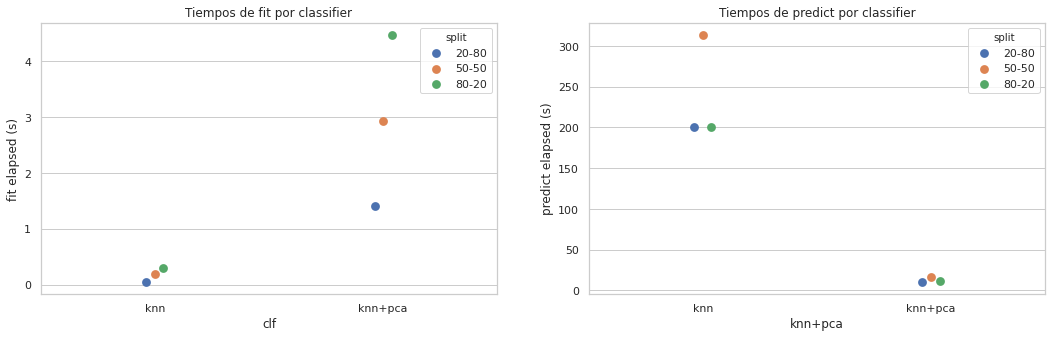

In [69]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 5))
sns.set(style="whitegrid")

plot = sns.pointplot(data=df, x="clf", y="fit_elapsed", hue="split", ax=ax1, join=False, dodge=True)
plot.set(ylabel="fit elapsed (s)")
plot.set_title("Tiempos de fit por classifier")

plot = sns.pointplot(data=df, x="clf", y="predict_elapsed", hue="split", ax=ax2, join=False, dodge=True)
plot.set(ylabel="predict elapsed (s)", xlabel="knn+pca")
plot.set_title("Tiempos de predict por classifier")



Text(0.5, 1.0, 'Tiempos de predict para knn+pca')

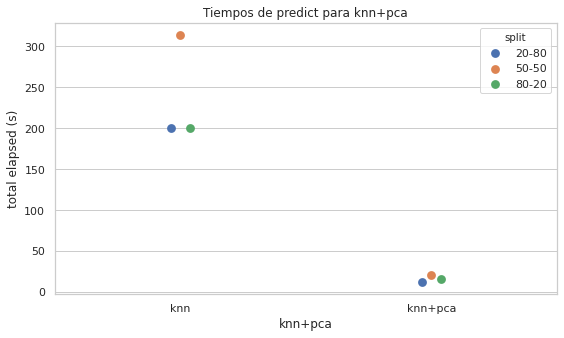

In [67]:
import matplotlib.pyplot as plt
import seaborn as sns

fig= plt.figure(figsize=(9, 5))
sns.set(style="whitegrid")

plot = sns.pointplot(data=df, x="clf", y="total_elapsed", hue="split", join=False, dodge=True)
plot.set(ylabel="total elapsed (s)", xlabel="knn+pca")
plot.set_title("Tiempos totales por classifier")



In [62]:
import seaborn as sns
df_pivot = df.pivot("K", "sample_size", "accuracy")
ax = sns.heatmap(data=df_pivot, annot=True, fmt=".2f")
ax.invert_yaxis()

KeyError: 'K'

In [ ]:
## concluimos que distance_pow es el mejor
## TODO: graficar cosas